<a href="https://colab.research.google.com/github/Karolina-Bogacka/transbajki/blob/master/time_series_fbprophet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !pip install pystan==2.19.1.1
# !pip install prophet

In [2]:
# !git clone https://github.com/Karolina-Bogacka/transbajki.git

In [1]:
from prophet import Prophet
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import transbajki.utils as utils
import pandas as pd
from google.colab import drive
import logging
logging.getLogger('prophet').setLevel(logging.WARNING) 
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
PATH = '/content/drive/MyDrive/transbajki/nextbike_data'
bikes = utils.read_bikes(PATH)

In [3]:
stations = utils.get_stations()

In [4]:
bikes = bikes[bikes["date"].isin(
    bikes["date"].groupby([bikes["date"].dt.hour, bikes["date"].dt.day, bikes["date"].dt.month]).max()
    )] #downsampling - last obs in given hour
grouped = utils.rented_returned_amount(bikes, stations)
grouped

,date,station_id,bike_count,just_returned,just_rented,uid,lat,lng,name,bike_racks,place_type
0,2022-04-24 15:51:00,448565,4,4,0.0,448565,52.183992,21.009840,Nestle House,15,0
1,2022-04-24 16:51:00,448565,5,4,3.0,448565,52.183992,21.009840,Nestle House,15,0
2,2022-04-24 17:51:00,448565,8,3,0.0,448565,52.183992,21.009840,Nestle House,15,0
3,2022-04-24 18:51:00,448565,8,1,1.0,448565,52.183992,21.009840,Nestle House,15,0
4,2022-04-24 19:51:00,448565,8,0,0.0,448565,52.183992,21.009840,Nestle House,15,0
...,...,...,...,...,...,...,...,...,...,...,...
409595,2022-06-13 15:54:00,3110680,22,0,1.0,3110680,52.249684,21.092105,Szaserów – Garwolińska,26,0
409596,2022-06-13 16:54:00,3110680,23,1,0.0,3110680,52.249684,21.092105,Szaserów – Garwolińska,26,0
409597,2022-06-13 17:54:00,3110680,21,1,3.0,3110680,52.249684,21.092105,Szaserów – Garwolińska,26,0
409598,2022-06-13 18:54:00,3110680,21,0,0.0,3110680,52.249684,21.092105,Szaserów – Garwolińska,26,0


In [5]:
grouped['ds']=grouped['date']
grouped['y']=grouped['bike_count']

In [6]:
train = grouped[grouped["date"].dt.date <= (datetime.now() - timedelta(days=5)).date()]
test = grouped[grouped["date"].dt.date > (datetime.now() - timedelta(days=5)).date()]

In [7]:
m={}
for station_name in grouped['name'].unique()[100:]:
  m[station_name] = Prophet()
  m[station_name].fit(train[train["name"] == station_name])

In [8]:
future = m['Metro Stokłosy'].make_future_dataframe(periods=24*5, freq='h')
future

,ds
0,2022-04-24 15:51:00
1,2022-04-24 16:51:00
2,2022-04-24 17:51:00
3,2022-04-24 18:51:00
4,2022-04-24 19:51:00
...,...
1204,2022-06-13 19:54:00
1205,2022-06-13 20:54:00
1206,2022-06-13 21:54:00
1207,2022-06-13 22:54:00


In [9]:
forecast = m['Metro Stokłosy'].predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1204,2022-06-13 19:54:00,23.237764,14.956970,30.863648
1205,2022-06-13 20:54:00,24.320788,16.148219,32.631088
1206,2022-06-13 21:54:00,24.767219,16.647668,33.231764
1207,2022-06-13 22:54:00,24.678458,15.966891,32.273452
1208,2022-06-13 23:54:00,24.491958,16.534086,32.687618


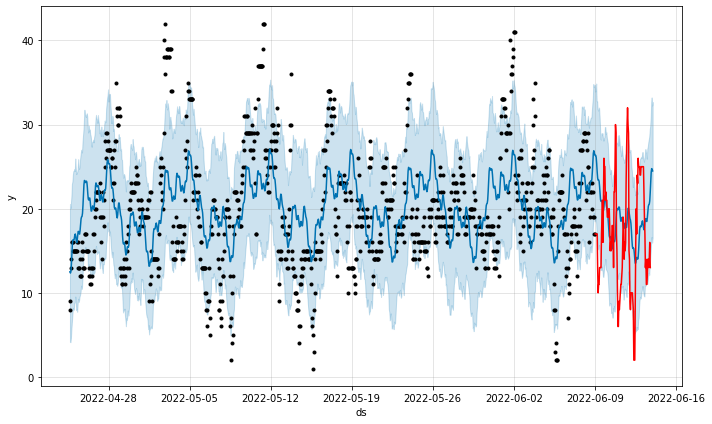

In [10]:
_ = m['Metro Stokłosy'].plot(forecast)
plt.plot(test[test["name"] == "Metro Stokłosy"]["date"], test[test["name"] == "Metro Stokłosy"]["bike_count"], c='r')

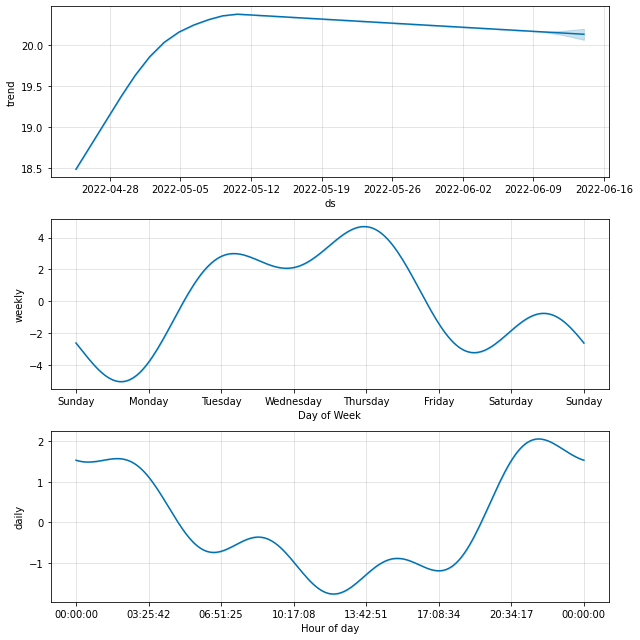

In [11]:
_ = m['Metro Stokłosy'].plot_components(forecast)


In [20]:
rmse_dict = {}
for station_name in m:
  forecast = m[station_name].predict(test.loc[test['name'] == station_name, ['ds']])
  test_val = test.loc[test['name'] == station_name, "bike_count"]
  rmse_dict[station_name] = mean_squared_error(forecast['yhat'], 
                                               test_val)**0.5

In [22]:
pd.Series(rmse_dict).sort_values()

Veturilko - Park Bródnowski                          0.454015
Veturilko - Kępa Potocka                             0.708236
Veturilko - Sanguszki - Wybrzeże Gdańskie            1.004712
Veturilko - Rondo Waszyngtona - Stadion Narodowy     1.046033
Bolero                                               1.180948
                                                      ...    
Arkadia                                              9.223405
Wybrzeże Szczecińskie - Stadion Narodowy            10.788513
Bulwar - most Śląsko - Dąbrowski                    10.839756
Metro Ursynów I                                     14.944542
Metro Centrum Nauki Kopernik                        16.949858
Length: 249, dtype: float64